In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import sklearn
%matplotlib inline
from sklearn import linear_model
from sklearn.model_selection import train_test_split
pd.options.display.float_format = '{:.3f}'.format

In [2]:
# Grab and process the raw data.
raw = pd.read_csv('fbi_data_2013.csv')
raw.columns = ['City','Population','Violent crime','Murder','Rape1','Rape2','Robbery','Aggravated Assault','Property Crime','Burglary','Larceny','MV Theft','Arson3']
raw.fillna(0, inplace=True)

In [3]:
# get some baseline info
raw.describe()

,Population,Violent crime,Murder,Rape1,Rape2,Robbery,Aggravated Assault,Property Crime,Burglary,Larceny,MV Theft,Arson3
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000
mean,40037.632,201.595,1.566,0.000,5.865,72.902,121.261,792.606,119.684,637.017,35.905,1.006
std,450037.368,2815.269,18.304,0.000,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424,7.885
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,0.000,0.000,0.000,1.000,40.500,6.000,31.000,0.000,0.000
50%,7233.500,6.000,0.000,0.000,0.000,1.000,4.000,112.500,17.500,94.000,2.000,0.000
75%,18427.500,22.000,0.000,0.000,2.000,5.000,14.000,341.000,51.250,287.250,7.000,0.000
max,8396126.000,52384.000,335.000,0.000,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,132.000


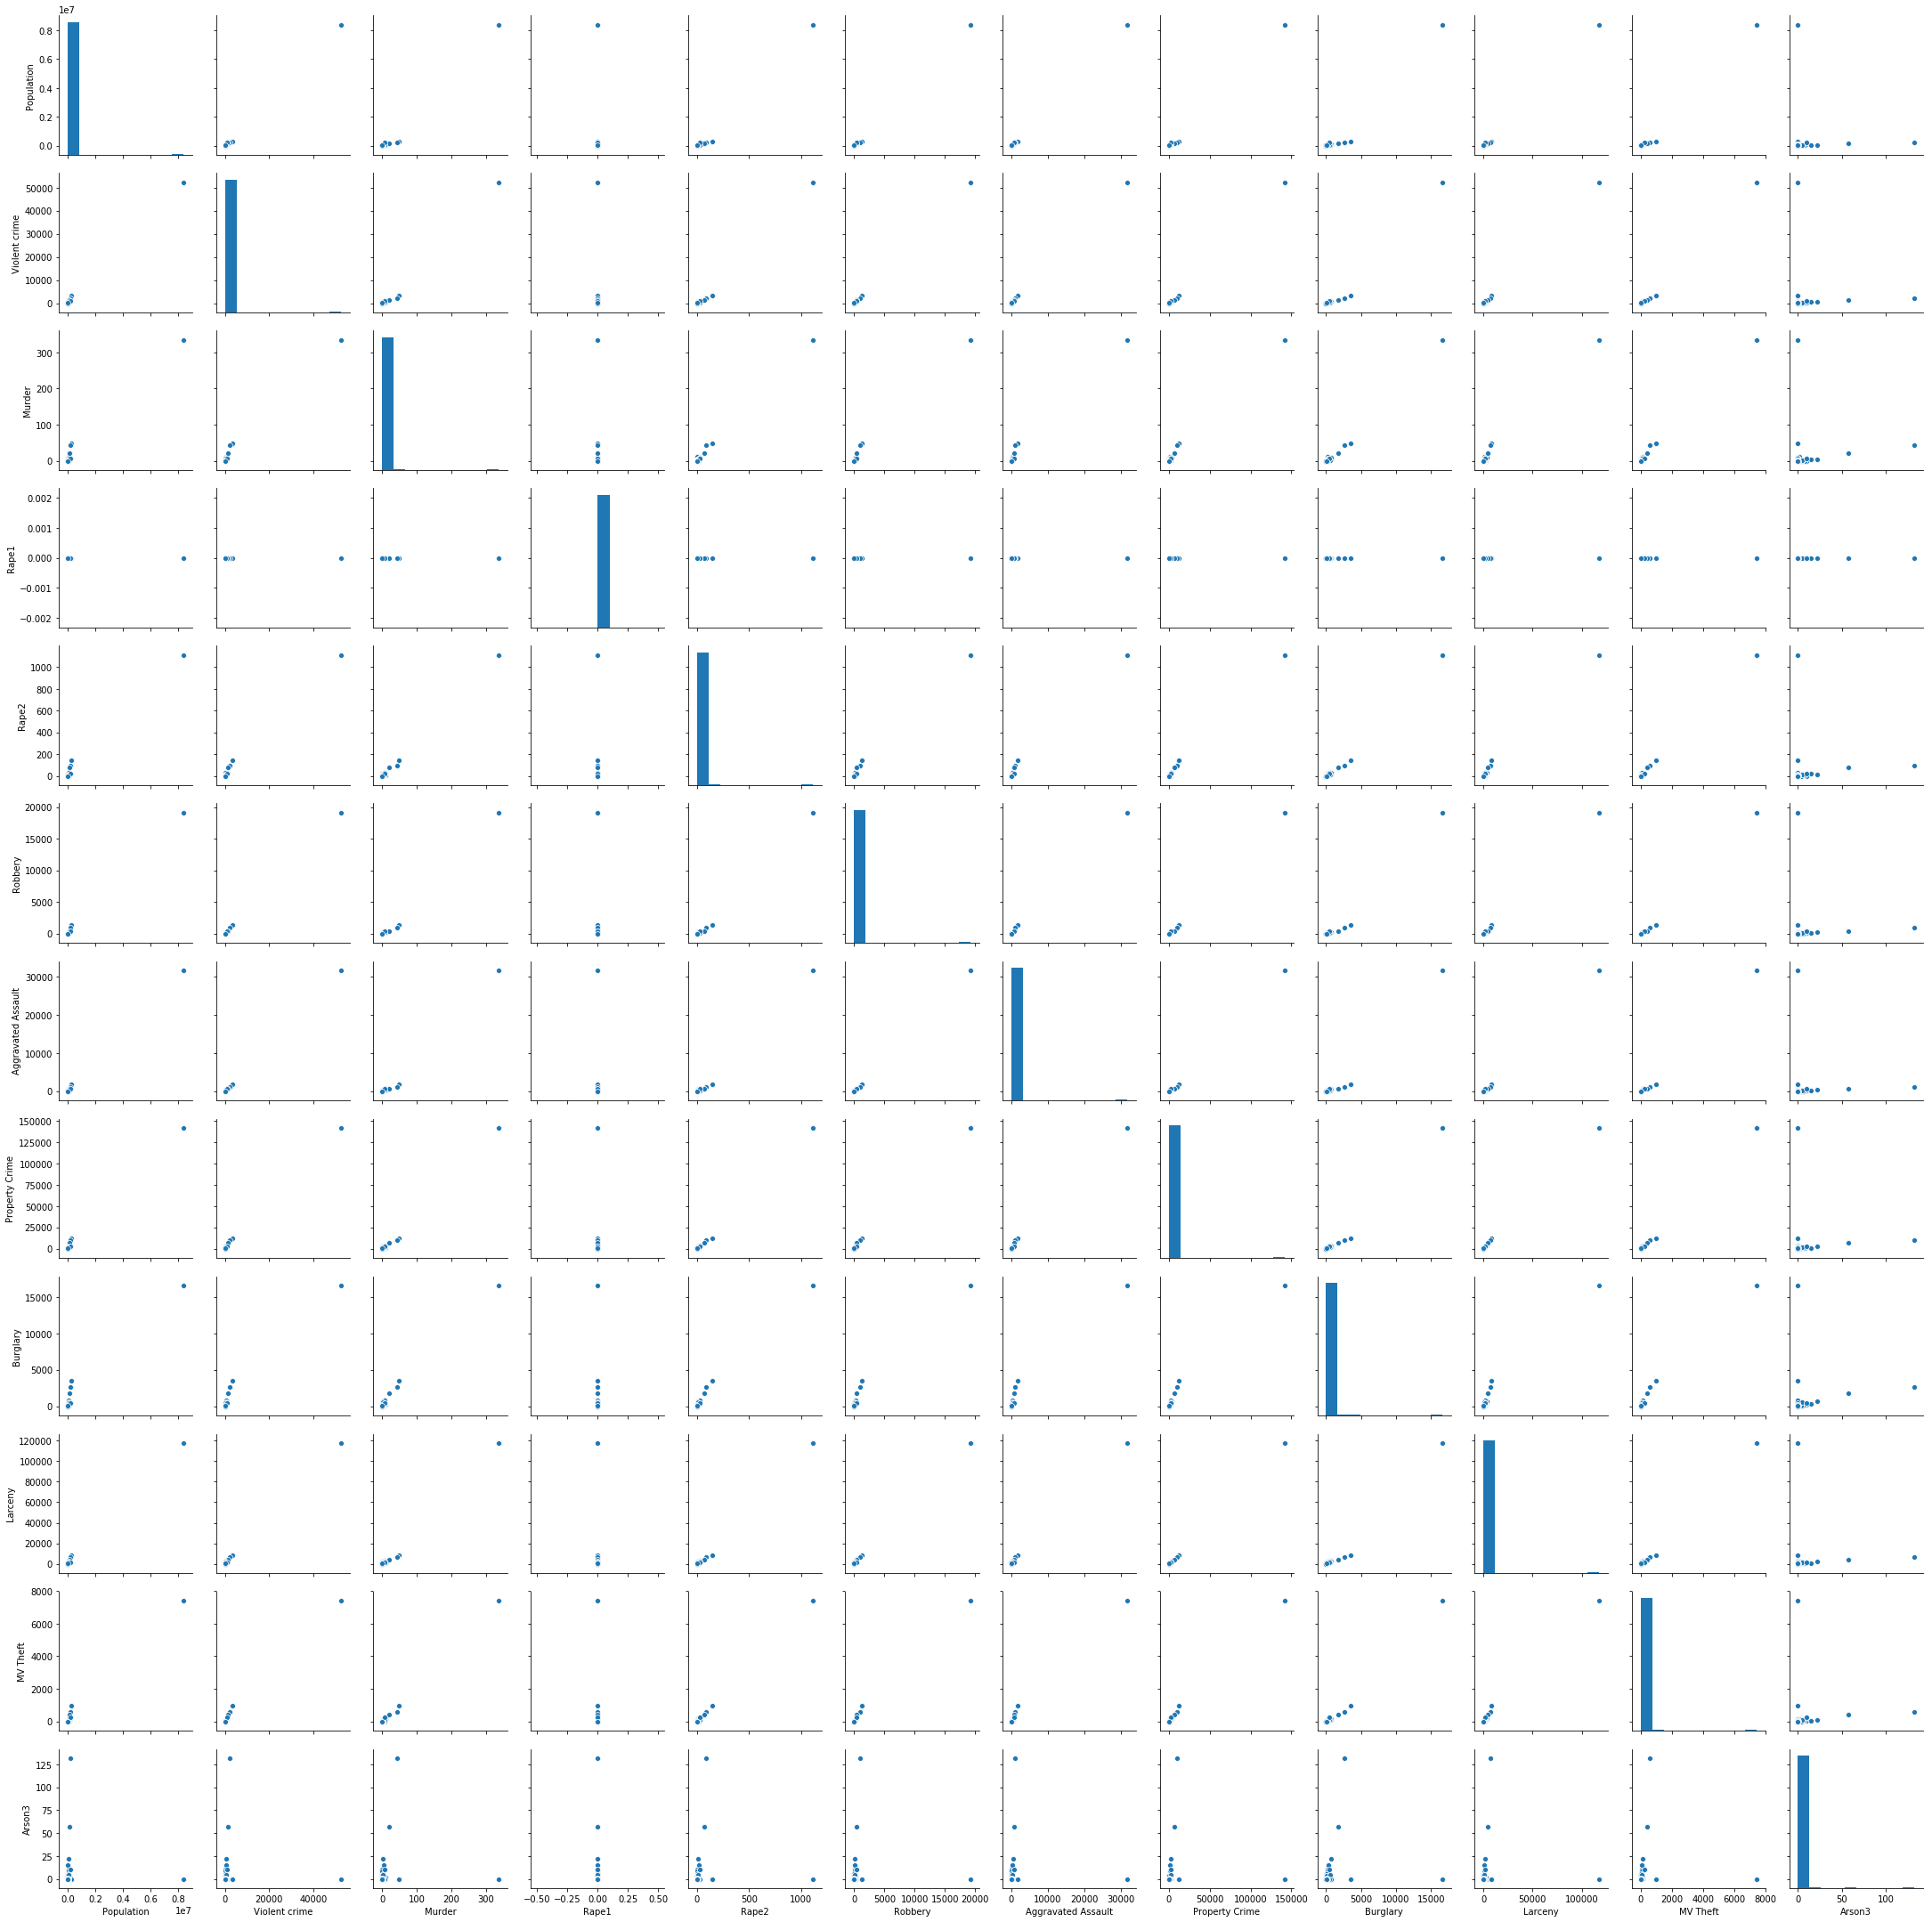

In [4]:
# take a look at data relationships
sns.pairplot(raw)

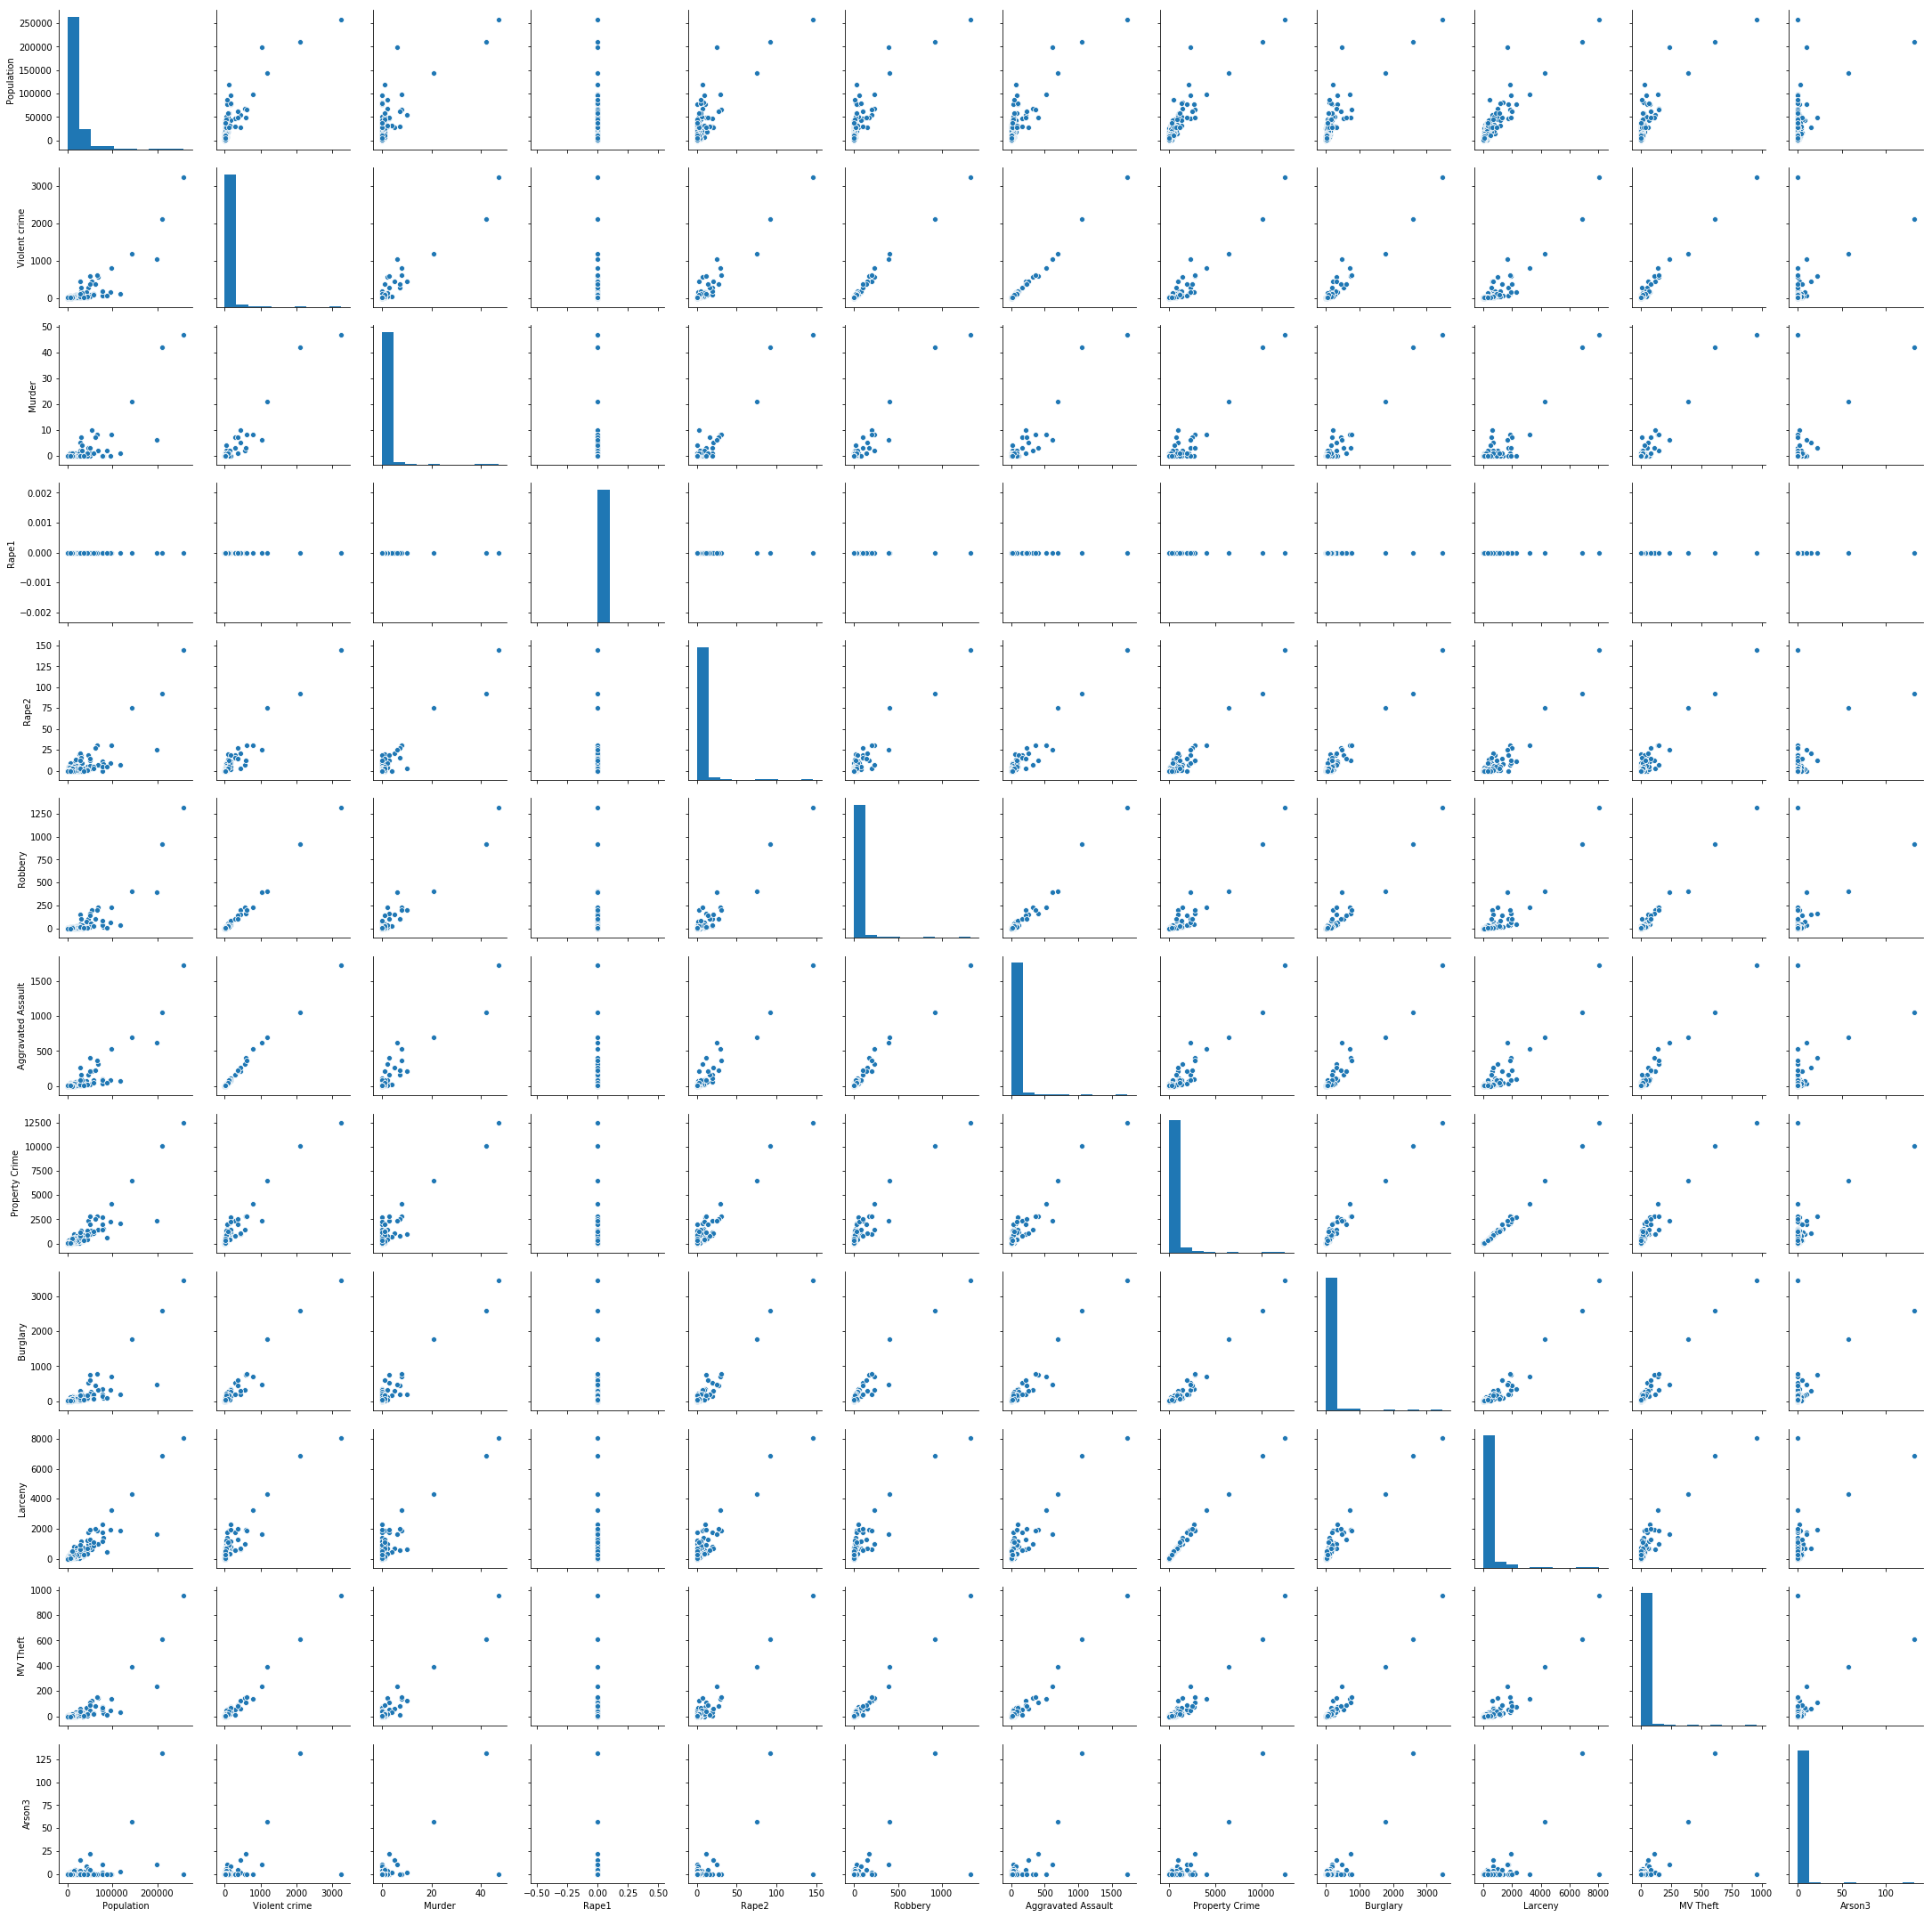

In [5]:
# They all seem to have a major outlier which ends up being NYC, so let's stratify that out and look again
sub_no_ny = raw[raw['City']!= "New York"]
sns.pairplot(sub_no_ny)

In [6]:
# Probably should stratify base on population
# Highest strata = pop > 1,000,000  -- this is just new york
# Next strata = pop > 97,000  -- this will pick up Albany which has high crime rate that could skew next strata
# Next strata = Pop > 45,000
# Next strata = Pop > 10,000
# First strata = pop < 10,000
strata = []
for pop in raw['Population']:
    if pop < 10000:
        strata.append("Less than 10,000")
    elif (pop >= 10000 and pop < 45000):
        strata.append("Less than 45,000")
    elif pop >= 45000 and pop < 97000:   
        strata.append("Less than 97,000")
    elif pop >= 97000 and pop < 1000000:
        strata.append("Less than 1,000,000")
    else:
        strata.append("NY City")
raw['Strata'] = strata
raw.head(20)

,City,Population,Violent crime,Murder,Rape1,Rape2,Robbery,Aggravated Assault,Property Crime,Burglary,Larceny,MV Theft,Arson3,Strata
0,Adams Village,1861,0,0,0.000,0,0,0,12,2,10,0,0.000,"Less than 10,000"
1,Addison Town and Village,2577,3,0,0.000,0,0,3,24,3,20,1,0.000,"Less than 10,000"
2,Akron Village,2846,3,0,0.000,0,0,3,16,1,15,0,0.000,"Less than 10,000"
3,Albany,97956,791,8,0.000,30,227,526,4090,705,3243,142,0.000,"Less than 1,000,000"
4,Albion Village,6388,23,0,0.000,3,4,16,223,53,165,5,0.000,"Less than 10,000"
5,Alfred Village,4089,5,0,0.000,0,3,2,46,10,36,0,0.000,"Less than 10,000"
6,Allegany Village,1781,3,0,0.000,0,0,3,10,0,10,0,0.000,"Less than 10,000"
7,Amherst Town,118296,107,1,0.000,7,31,68,2118,204,1882,32,3.000,"Less than 1,000,000"
8,Amityville Village,9519,9,0,0.000,2,4,3,210,16,188,6,1.000,"Less than 10,000"
9,Amsterdam,18182,30,0,0.000,0,12,18,405,99,291,15,0.000,"Less than 45,000"


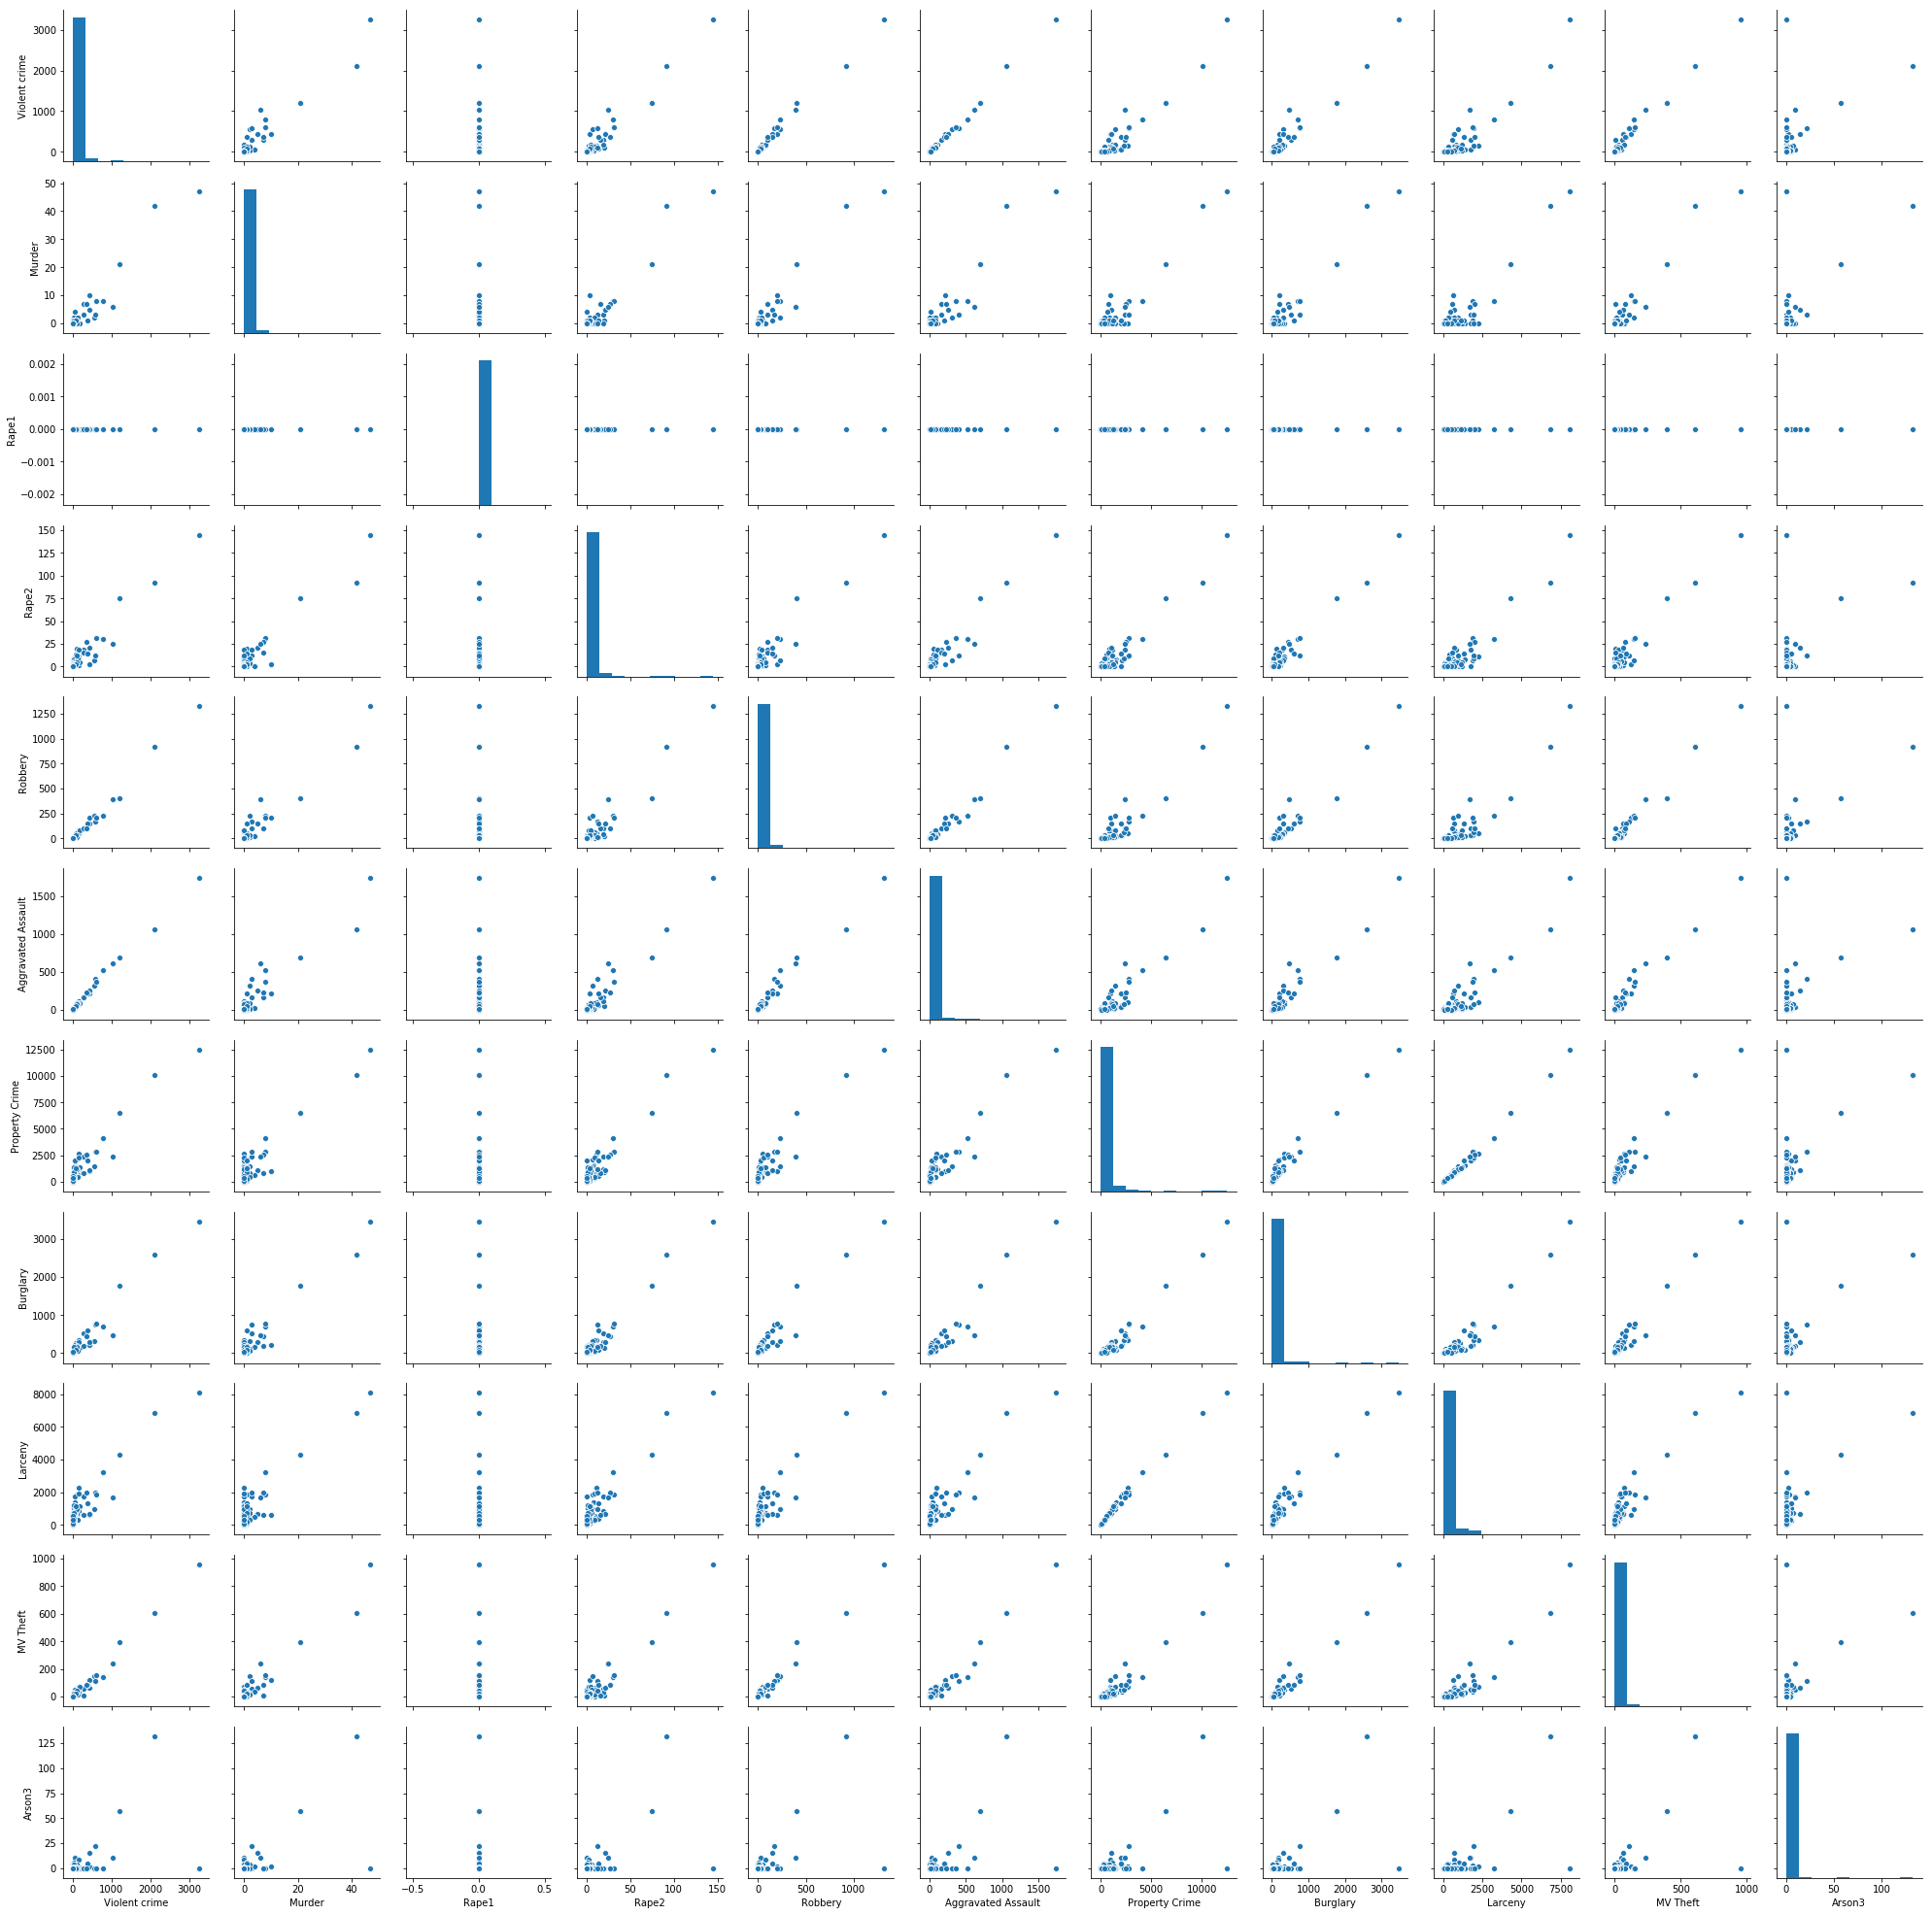

In [7]:
sub_strata = raw[['City','Strata','Violent crime','Murder','Rape1','Rape2','Robbery','Aggravated Assault','Property Crime','Burglary','Larceny','MV Theft','Arson3']][raw['City']!= "New York"]
sns.pairplot(sub_strata)

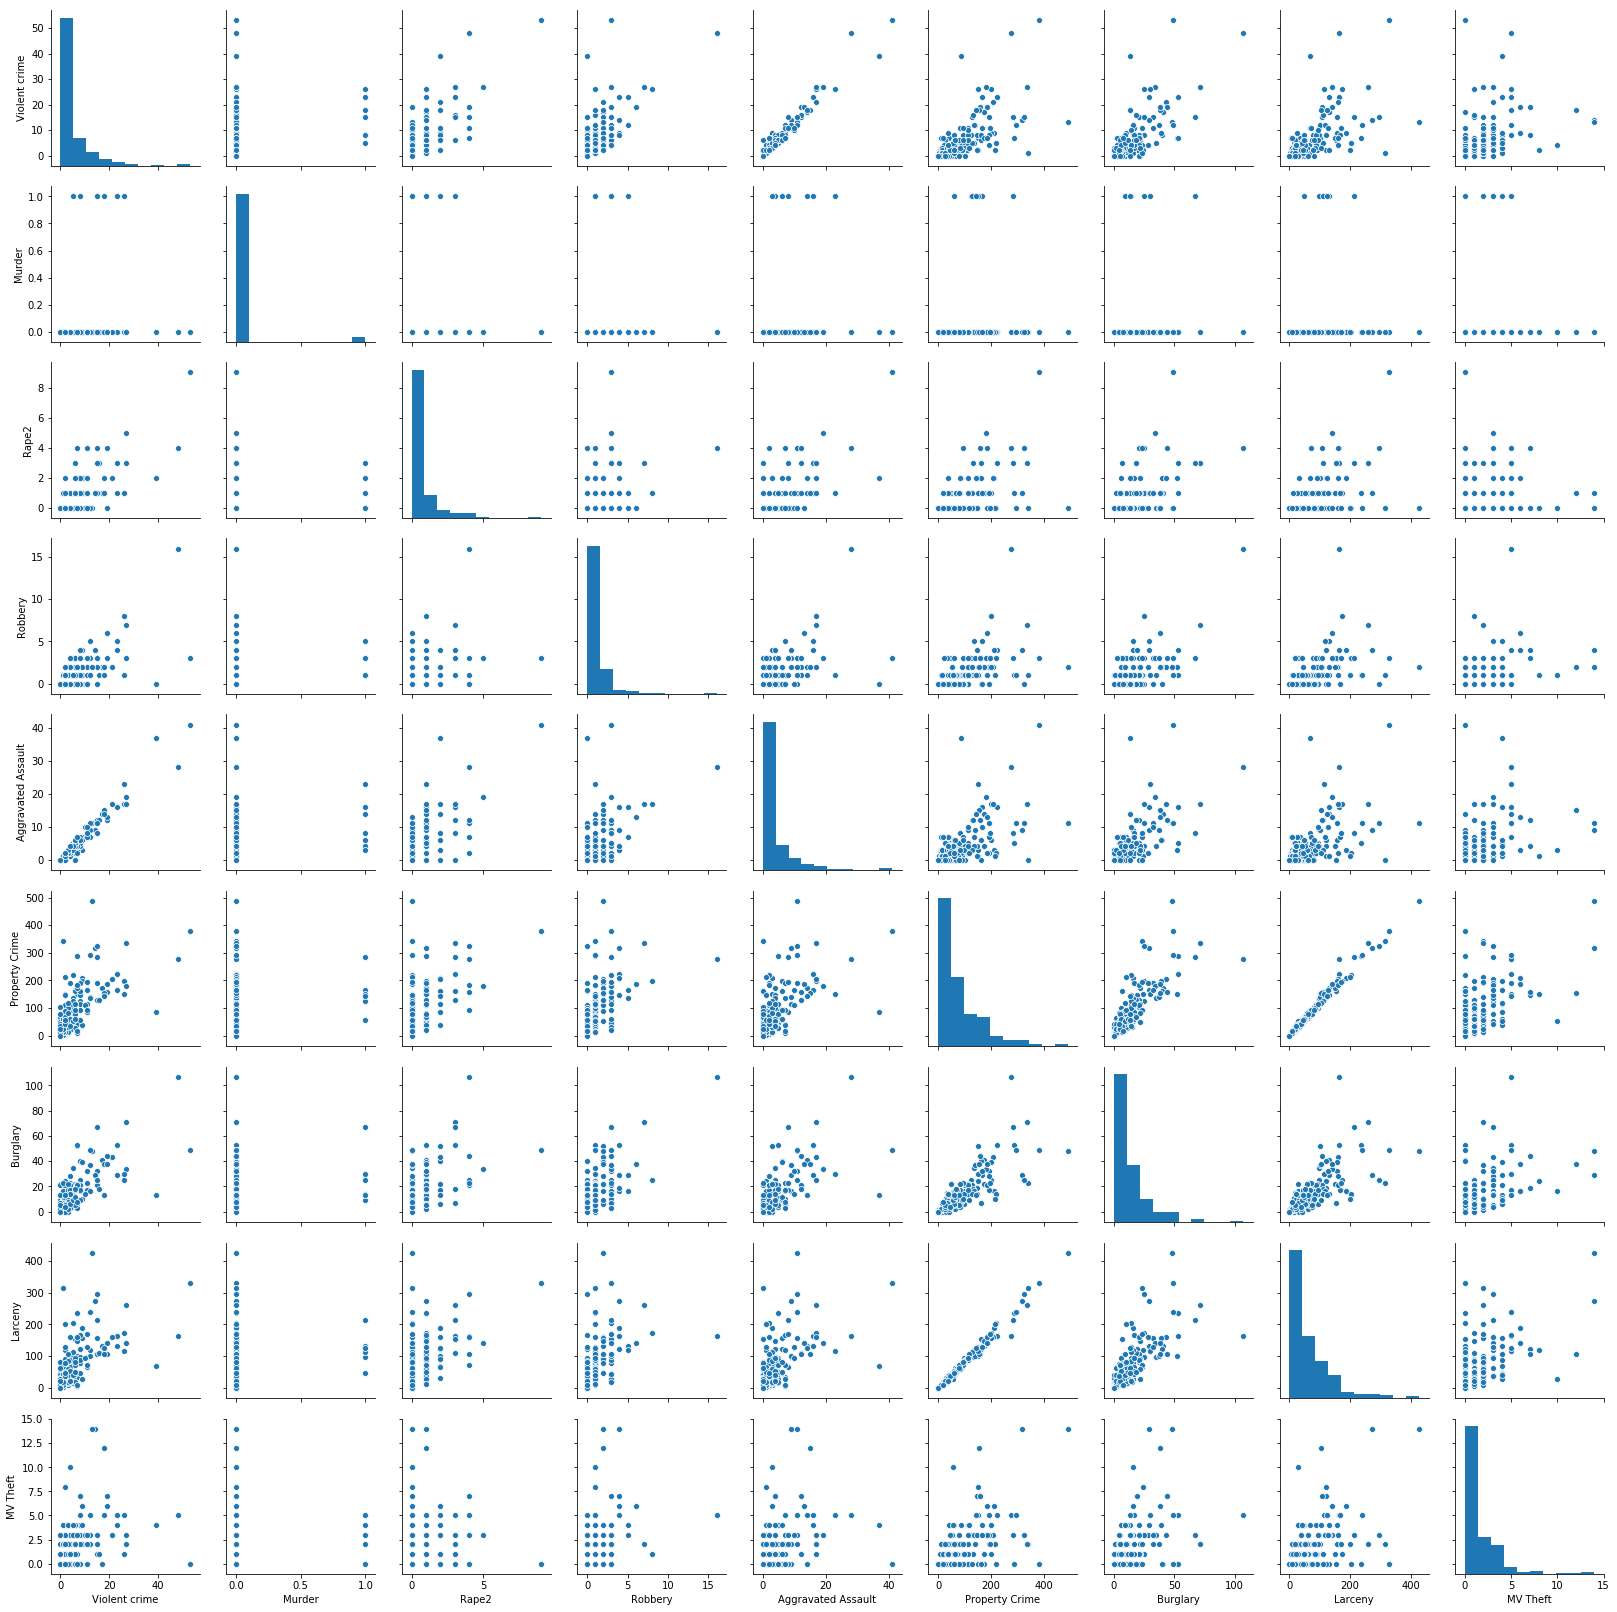

In [8]:
# that's too much.  let's break it into more viewable chunks removing rape1 and arson variables and looking at each strata
strata1 = raw[['City','Strata','Violent crime','Murder','Rape2','Robbery','Aggravated Assault','Property Crime','Burglary','Larceny','MV Theft']][raw['Strata'] == "Less than 10,000"]
sns.pairplot(strata1)

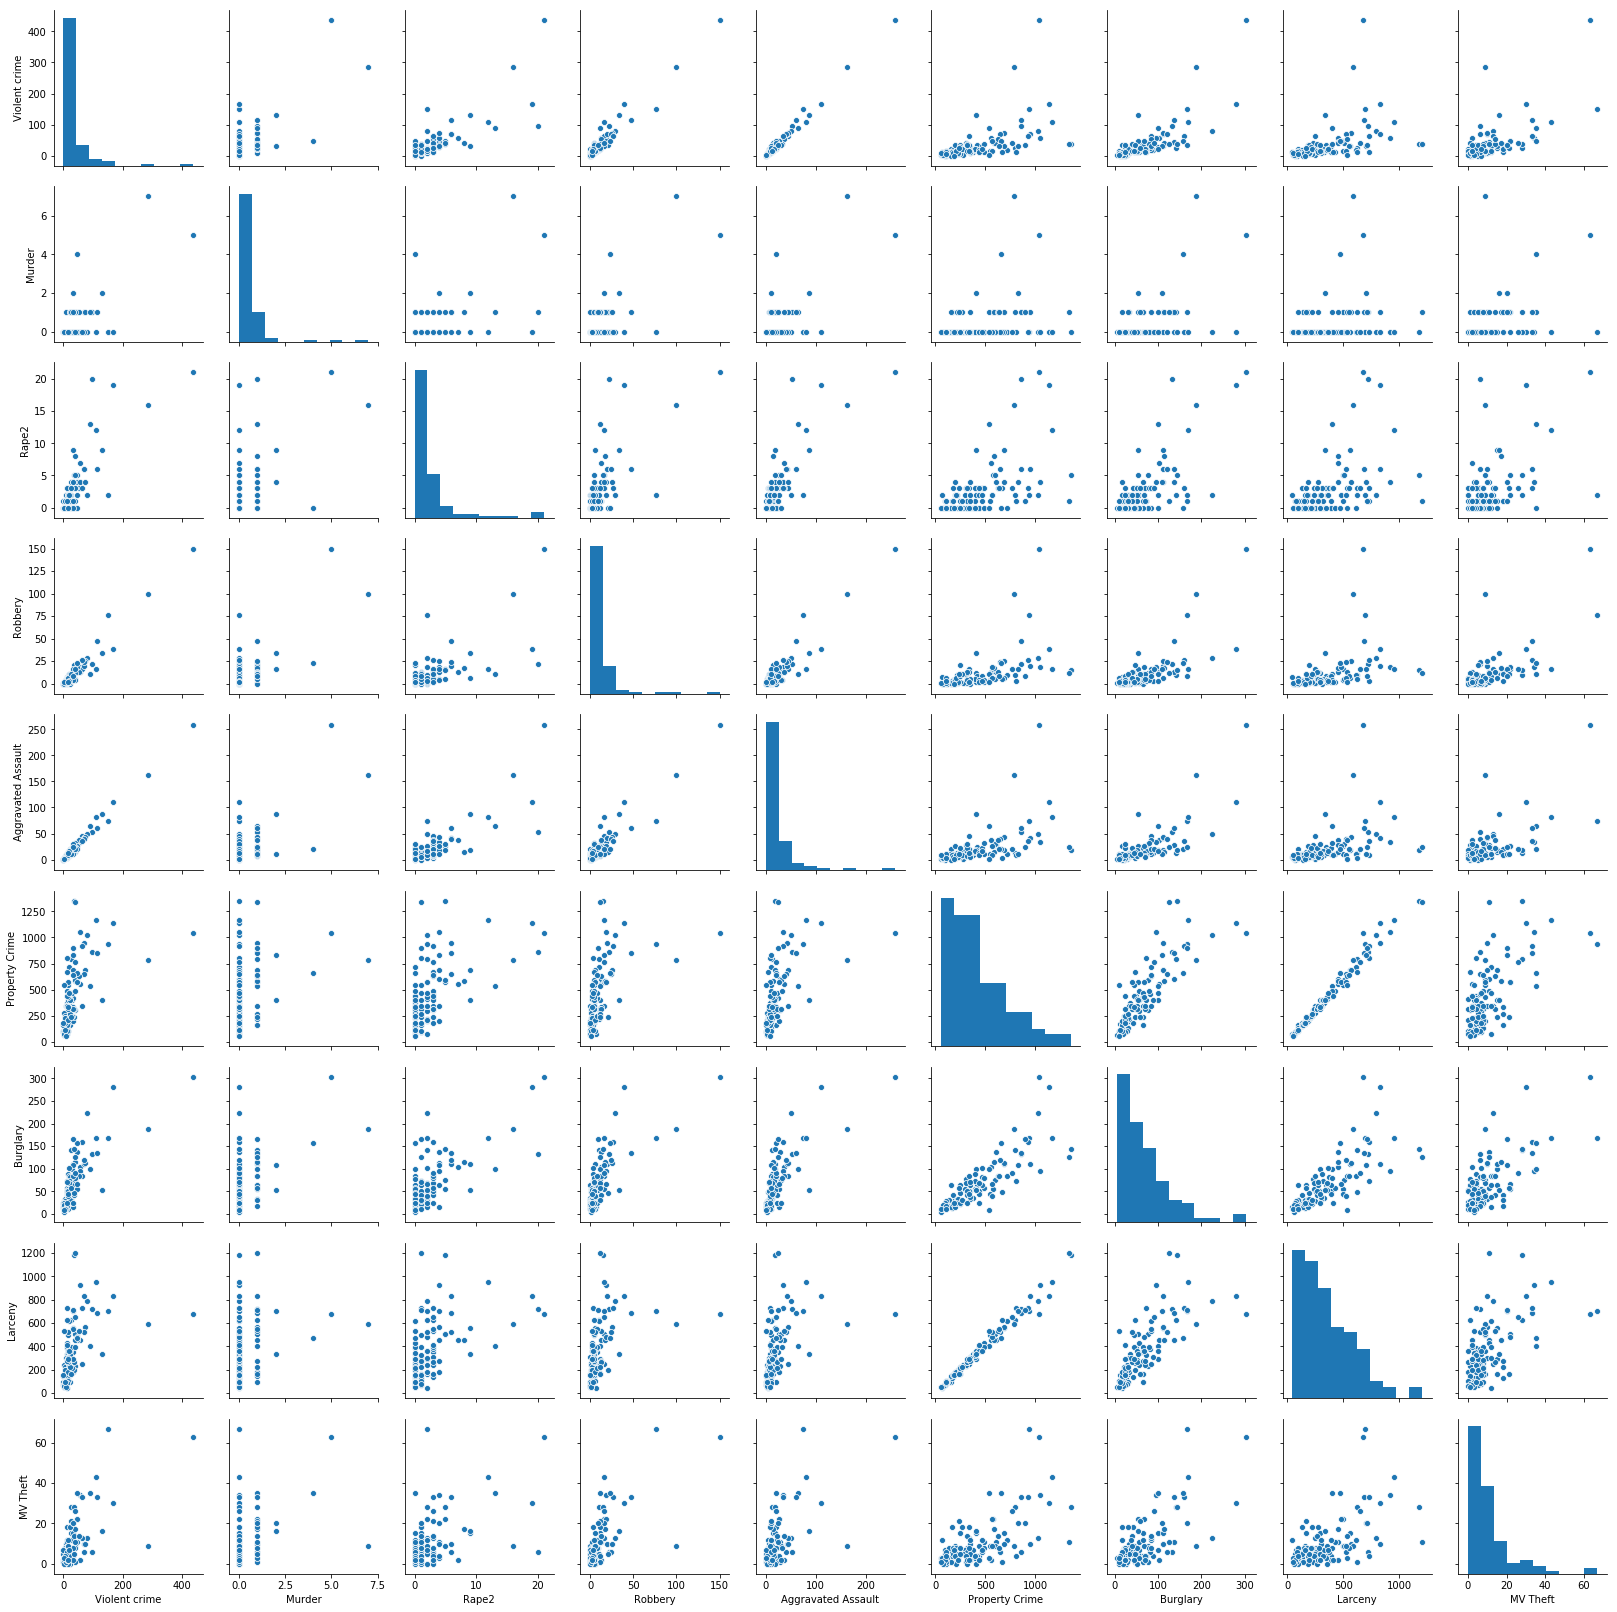

In [9]:
# Violent crime and aggravated assault, Larceny and property crime appear to have best correlation in strat1
strata2 = raw[['City','Strata','Violent crime','Murder','Rape2','Robbery','Aggravated Assault','Property Crime','Burglary','Larceny','MV Theft']][raw['Strata'] == "Less than 45,000"]
sns.pairplot(strata2)

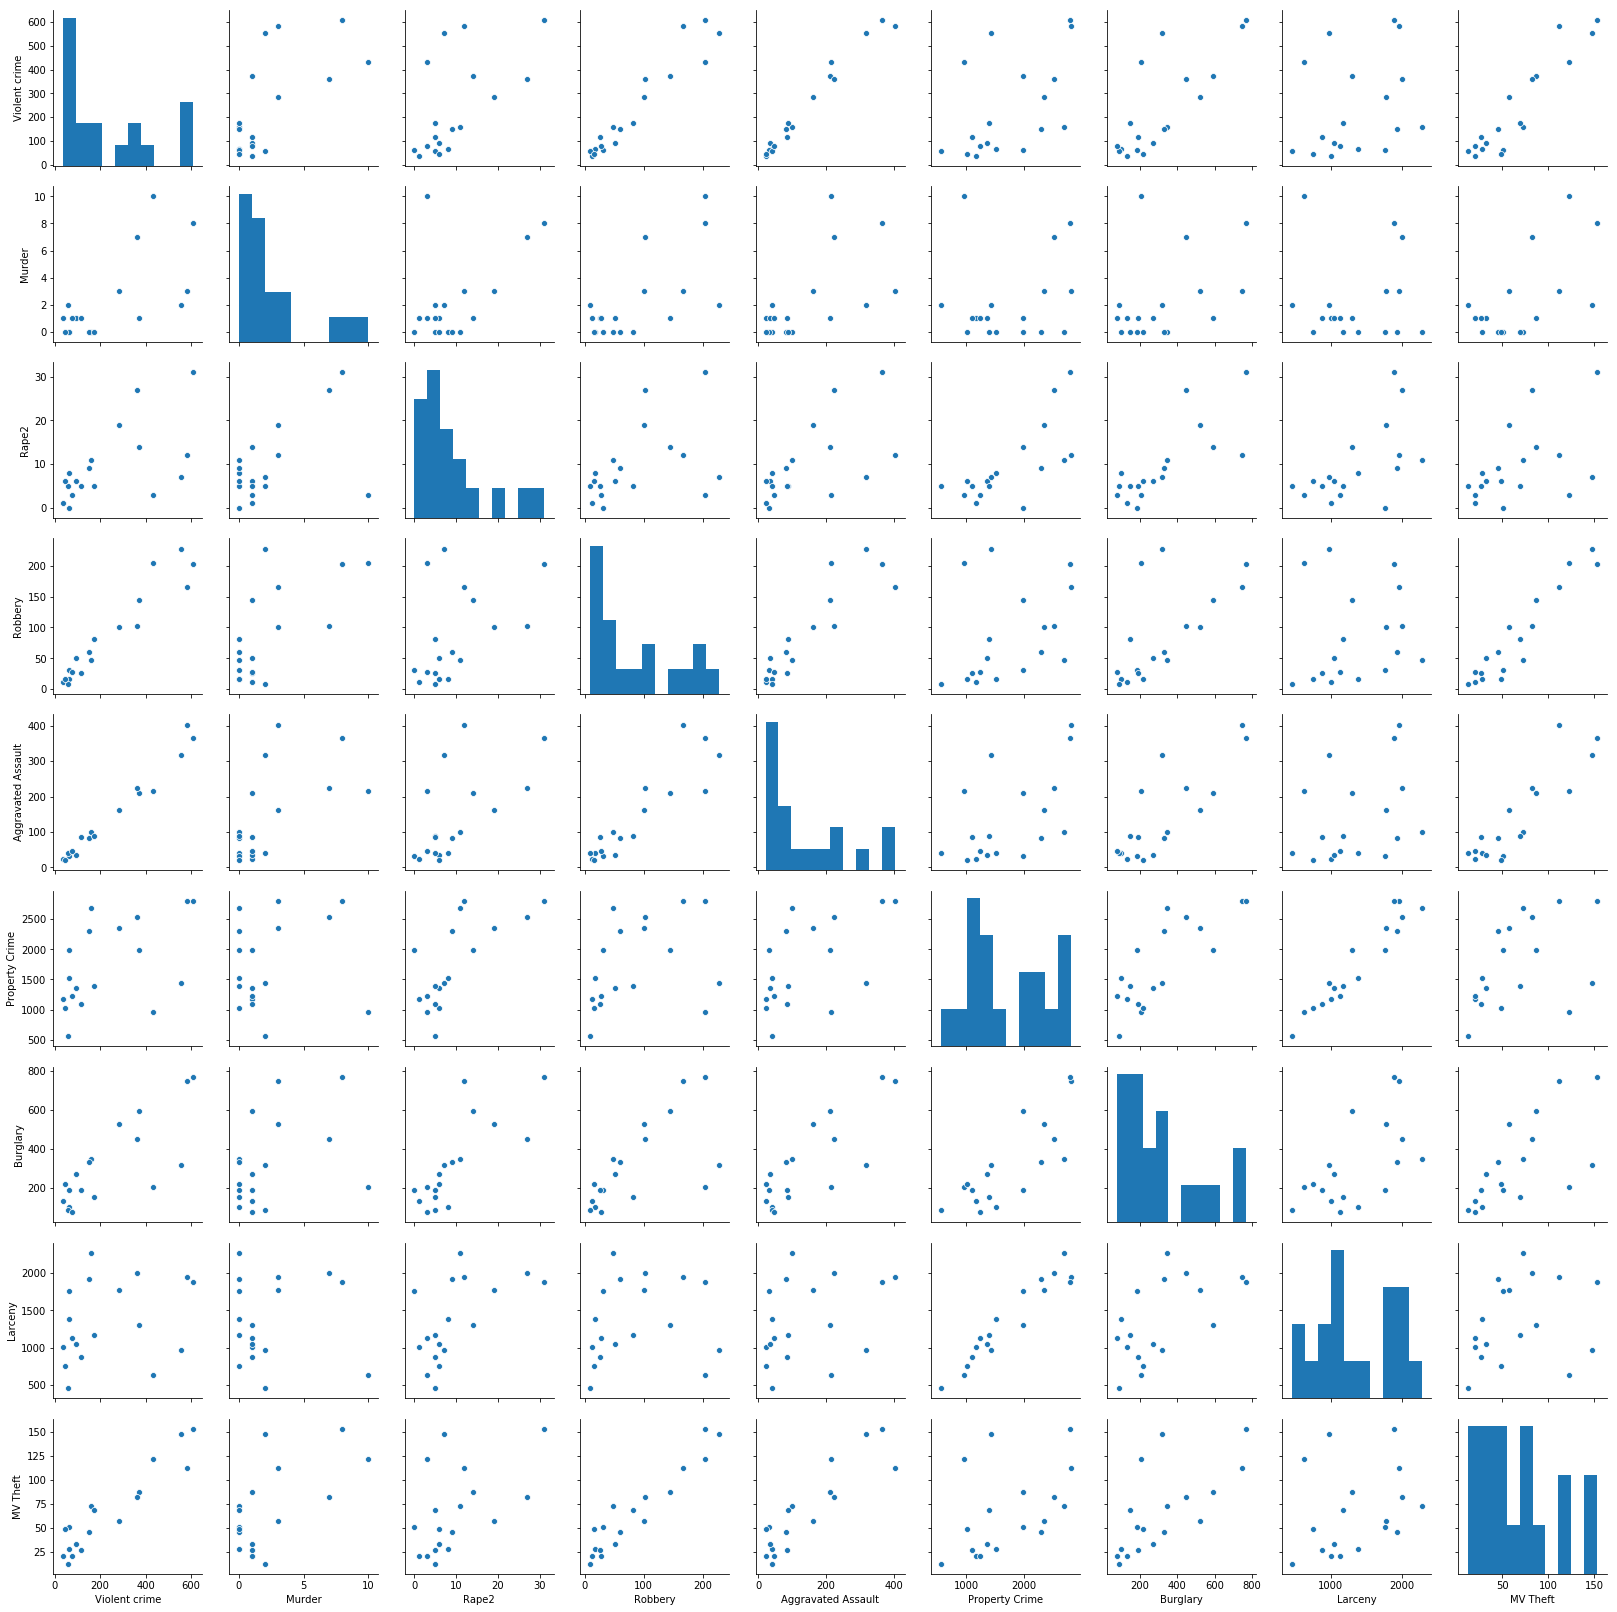

In [10]:
# Violent crime and aggravated assault, Larceny and property crime also appear to have best correlation in strat2
strata3 = raw[['City','Strata','Violent crime','Murder','Rape2','Robbery','Aggravated Assault','Property Crime','Burglary','Larceny','MV Theft']][raw['Strata'] == "Less than 97,000"]
sns.pairplot(strata3)

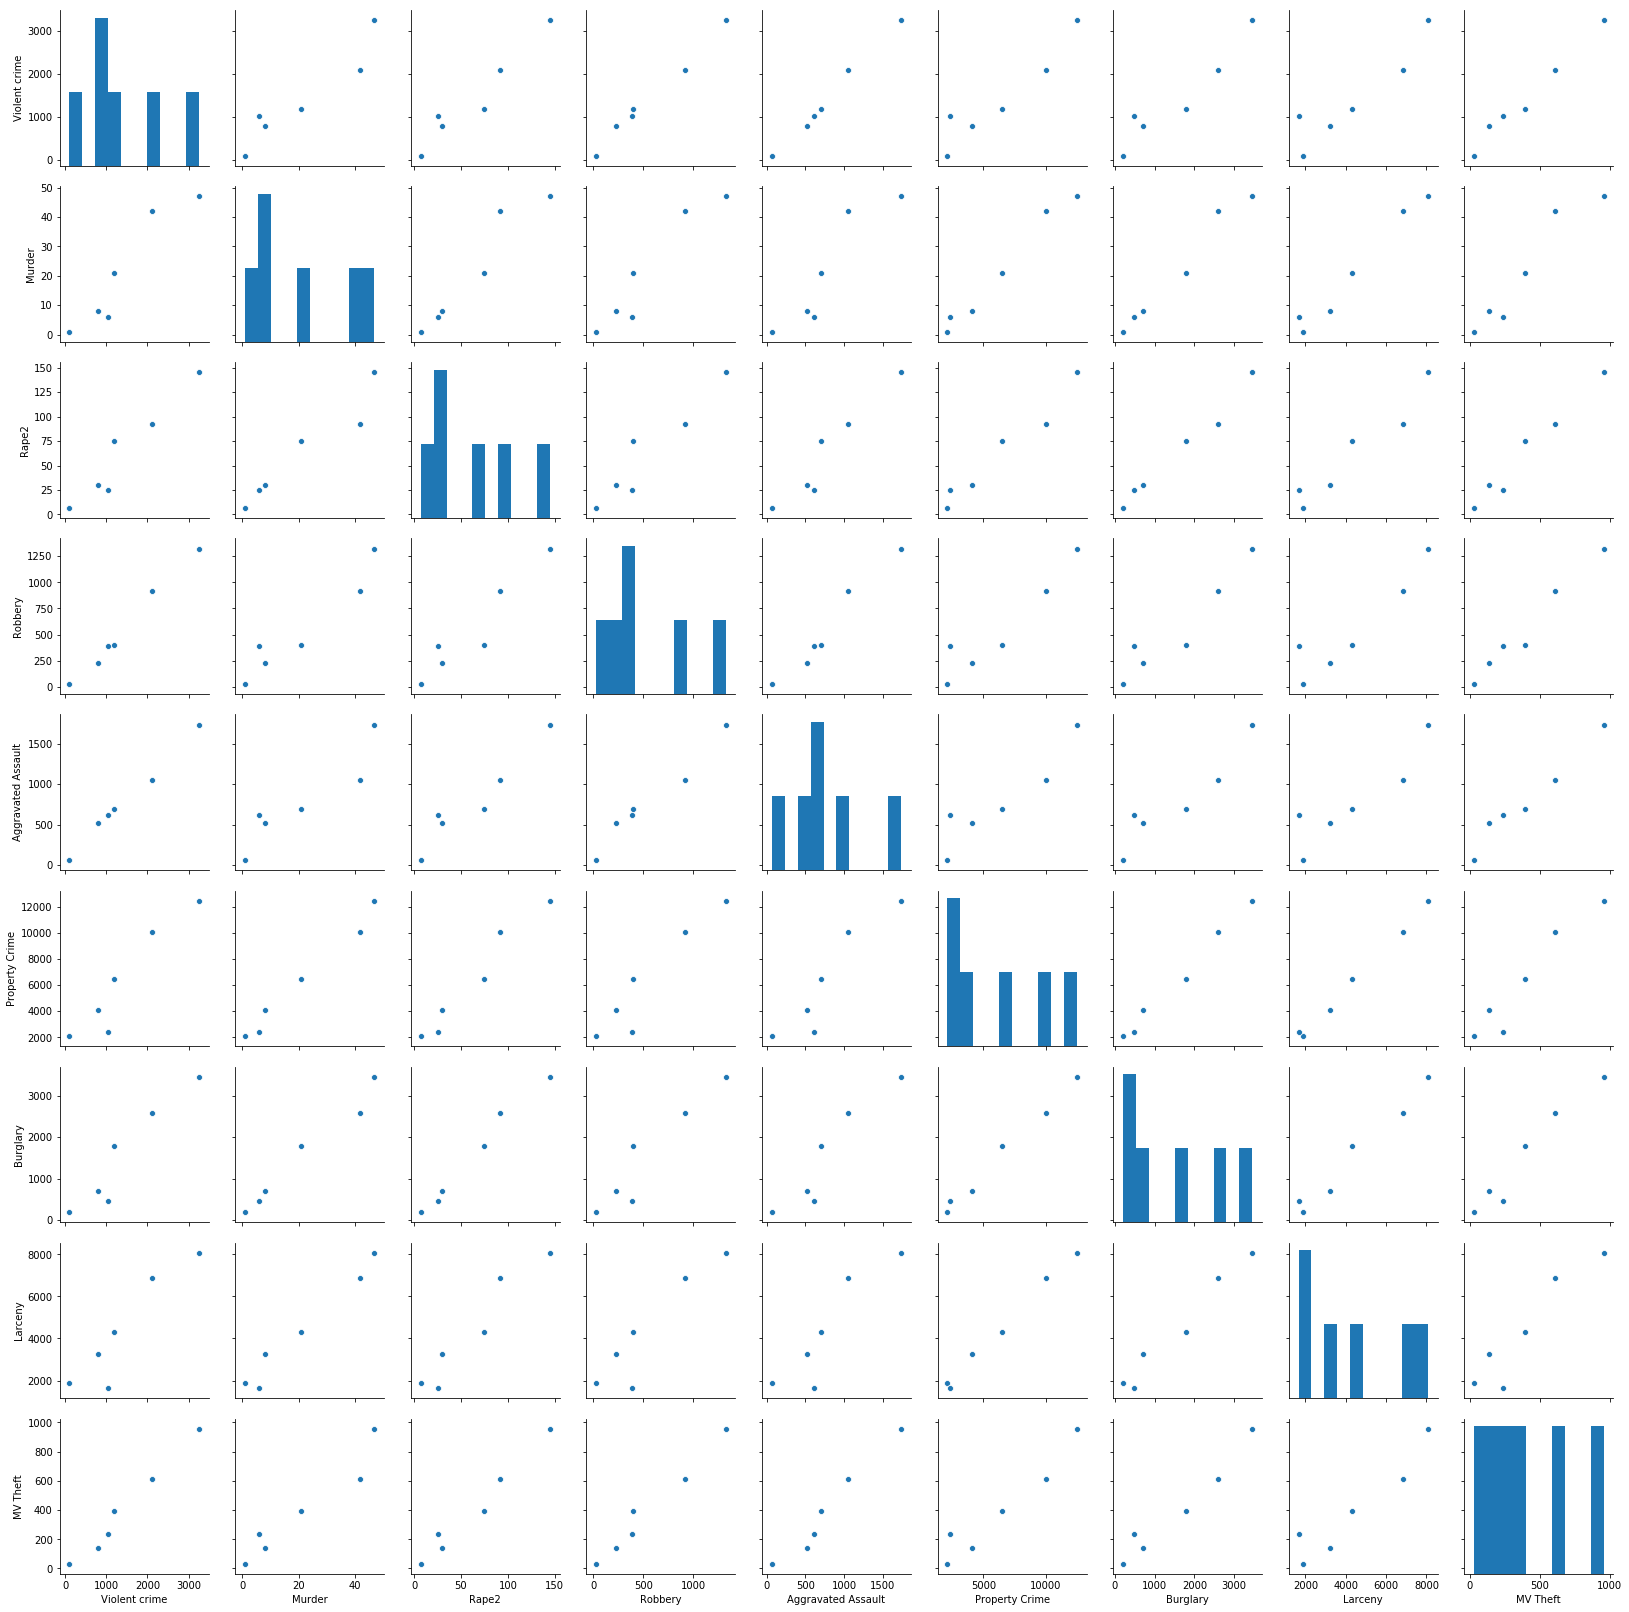

In [11]:
#  In the third strata, robbery also appears to have a pretty good correlation to violent crime and larceny
# has less relation to Property Crime than in the first 2 stratas.  Also, most variable were approaching a 
# log normal distribution in the first 2 strata - strata3 are all quite erratic
strata4 = raw[['City','Strata','Violent crime','Murder','Rape2','Robbery','Aggravated Assault','Property Crime','Burglary','Larceny','MV Theft']][raw['Strata'] == "Less than 1,000,000"]
sns.pairplot(strata4)
# Note: not running final strata as only one data point (NYC)

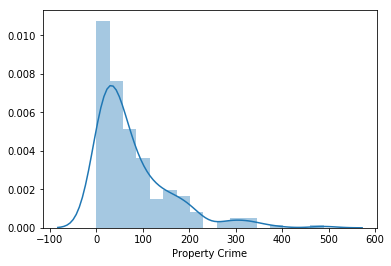

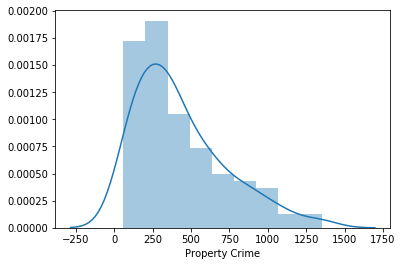

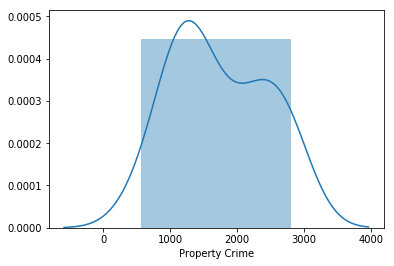

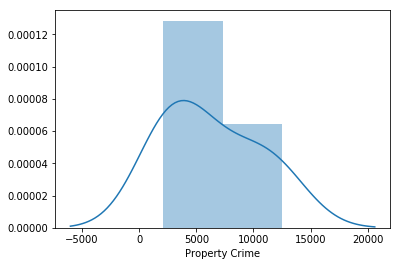

In [12]:
# Interestingly, the strata with the fewest data points gives the greatest appearance of correlation between variables
# Let's take a look at the variable we want to predict
sns.distplot(strata1['Property Crime'])
plt.show()
sns.distplot(strata2['Property Crime'])
plt.show()
sns.distplot(strata3['Property Crime'])
plt.show()
sns.distplot(strata4['Property Crime'])
plt.show()

In [13]:
# Let's look at the stratas by the numbers
strata1.corr()

,Violent crime,Murder,Rape2,Robbery,Aggravated Assault,Property Crime,Burglary,Larceny,MV Theft
Violent crime,1.000,0.236,0.743,0.685,0.975,0.669,0.742,0.621,0.389
Murder,0.236,1.000,0.095,0.140,0.222,0.166,0.177,0.154,0.137
Rape2,0.743,0.095,1.000,0.400,0.673,0.558,0.578,0.531,0.169
Robbery,0.685,0.140,0.400,1.000,0.533,0.577,0.695,0.522,0.373
Aggravated Assault,0.975,0.222,0.673,0.533,1.000,0.606,0.663,0.563,0.369
Property Crime,0.669,0.166,0.558,0.577,0.606,1.000,0.812,0.992,0.557
Burglary,0.742,0.177,0.578,0.695,0.663,0.812,1.000,0.732,0.449
Larceny,0.621,0.154,0.531,0.522,0.563,0.992,0.732,1.000,0.531
MV Theft,0.389,0.137,0.169,0.373,0.369,0.557,0.449,0.531,1.000


In [14]:
# For Property crime in strata 1, the highest correlations are larceny then burglary; 
# violent crime and aggravated assault are next closest
strata2.corr()

,Violent crime,Murder,Rape2,Robbery,Aggravated Assault,Property Crime,Burglary,Larceny,MV Theft
Violent crime,1.000,0.720,0.793,0.963,0.991,0.544,0.766,0.455,0.646
Murder,0.720,1.000,0.526,0.724,0.687,0.319,0.495,0.257,0.367
Rape2,0.793,0.526,1.000,0.666,0.799,0.554,0.695,0.490,0.477
Robbery,0.963,0.724,0.666,1.000,0.924,0.519,0.731,0.431,0.676
Aggravated Assault,0.991,0.687,0.799,0.924,1.000,0.530,0.754,0.442,0.616
Property Crime,0.544,0.319,0.554,0.519,0.530,1.000,0.833,0.990,0.628
Burglary,0.766,0.495,0.695,0.731,0.754,0.833,1.000,0.749,0.685
Larceny,0.455,0.257,0.490,0.431,0.442,0.990,0.749,1.000,0.557
MV Theft,0.646,0.367,0.477,0.676,0.616,0.628,0.685,0.557,1.000


In [15]:
# For Property crime in strata 2, the highest correlations are larceny then burglary with
# MV theft a fair distance behind
strata3.corr()

,Violent crime,Murder,Rape2,Robbery,Aggravated Assault,Property Crime,Burglary,Larceny,MV Theft
Violent crime,1.000,0.666,0.601,0.959,0.988,0.517,0.787,0.288,0.933
Murder,0.666,1.000,0.529,0.665,0.619,0.184,0.411,0.026,0.622
Rape2,0.601,0.529,1.000,0.457,0.617,0.713,0.784,0.582,0.507
Robbery,0.959,0.665,0.457,1.000,0.906,0.369,0.655,0.145,0.950
Aggravated Assault,0.988,0.619,0.617,0.906,1.000,0.563,0.819,0.339,0.893
Property Crime,0.517,0.184,0.713,0.369,0.563,1.000,0.802,0.957,0.469
Burglary,0.787,0.411,0.784,0.655,0.819,0.802,1.000,0.600,0.672
Larceny,0.288,0.026,0.582,0.145,0.339,0.957,0.600,1.000,0.266
MV Theft,0.933,0.622,0.507,0.950,0.893,0.469,0.672,0.266,1.000


In [16]:
# For Property crime in strata 3, the highest correlations are again larceny then burglary and
# rape2 is not too far behind in this strata
strata4.corr()

,Violent crime,Murder,Rape2,Robbery,Aggravated Assault,Property Crime,Burglary,Larceny,MV Theft
Violent crime,1.000,0.944,0.963,0.994,0.996,0.945,0.952,0.926,0.990
Murder,0.944,1.000,0.961,0.954,0.917,0.990,0.987,0.985,0.960
Rape2,0.963,0.961,1.000,0.950,0.958,0.978,0.992,0.961,0.985
Robbery,0.994,0.954,0.950,1.000,0.980,0.946,0.949,0.929,0.986
Aggravated Assault,0.996,0.917,0.958,0.980,1.000,0.927,0.937,0.906,0.980
Property Crime,0.945,0.990,0.978,0.946,0.927,1.000,0.995,0.997,0.963
Burglary,0.952,0.987,0.992,0.949,0.937,0.995,1.000,0.984,0.977
Larceny,0.926,0.985,0.961,0.929,0.906,0.997,0.984,1.000,0.941
MV Theft,0.990,0.960,0.985,0.986,0.980,0.963,0.977,0.941,1.000


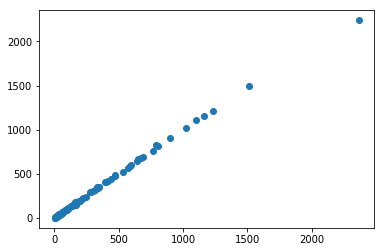

In [20]:
# As indicated in the graphs, all the variables seem to have strong correlation in this strata
# But larceny and burglary are again the top variables for property crime

# Let's see if we can set up a model, excluding New York, using larceny and burglary to predict Property Crime
X = raw[['Burglary','Larceny']][raw['City']!= "New York"]
y = raw['Property Crime'][raw['City']!= "New York"]
# Let's put 30% of the data into the test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(X_train,y_train)
predictions = regr.predict(X_test)
plt.scatter(y_test,predictions)

In [21]:
# Inspect the results.
regr.fit(X,y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, y))


Coefficients: 
 [1.2763613  0.98949047]

Intercept: 
 -2.2184961318855585

R-squared:
0.9998051274431816
